In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import seaborn as sns
import pickle
import gzip
from scipy.fft import fft, fftfreq

os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, xgboost_params

peakhalfwidth = 10

# These are batteries that show anomalies in the measnurements, and are therefore excluded.
excl_filenames = ['2018-04-12_batch8_CH46', '2017-06-30_3_6C-30per_6C_CH15', '2017-06-30_2C-7per_5_5C_CH12',
                  '2018-04-12_batch8_CH46', '2017-06-30_6C-60per_3C_CH48']

power = 16
nfft = np.power(2,power)
harmonics = 10

In [2]:
from functions.dataprep import create_Peak_Areas_df

# Obtain paths of all data files

In [3]:
data_dir = 'data/raw_data/'
data_files = [file for file in os.listdir(data_dir) if 'Meta' not in file 
              and 'sdu' not in file 
              and 'jena' not in file
              and 'png' not in file
              and 'pckl' not in file
              and '.DS_Store' not in file
              and 'CH' in file]


# Create PSD files

In [4]:
PSDs = []
CC_peaks_list = []
CV_peaks_list = []
for data_file in data_files[::]:
    if data_file.split('.')[0] not in excl_filenames:
        df_file = pd.read_csv(f'../Nature_battery/{data_dir+data_file}')
        df_file = df_file[(df_file["Cycle_Index"] >1) & (df_file["Cycle_Index"] < 103)]
        df_file = df_file.iloc[:nfft,:]
        data_file_prefix = data_file.split('.')[0]
        meta_data_file = data_file_prefix + '_Metadata.csv'
        schedule_version= pd.read_csv(data_dir+meta_data_file)["schedule_version"].values[0][-7:]
    
    
        df_file["CycleTime_hrs"] =  df_file["DateTime"]/3600
        dt = df_file["CycleTime_hrs"].diff().mean()
        
        dt_std = df_file["CycleTime_hrs"].diff().std()
    
        CC = df_file["Current"].values
        CC_FFT = fft(CC)
        CC_PSD = np.real(CC_FFT*np.conjugate(CC_FFT))
        
        CV = df_file["Voltage"].values
        CV_FFT = fft(CV)
        CV_PSD = np.real(CV_FFT*np.conjugate(CV_FFT))
        
        
        Freqs = fftfreq(n = CC_PSD.shape[0], 
                        d = dt
                       )
        alpha = 0.25
        if schedule_version == '7.00.13':
            color = 'blue'
        else:
            color = 'red'
            alpha /= 2
    
        CC_peaks_list.append(create_Peak_Areas_df(CC_PSD, dt, data_file,
                                                  harmonics = harmonics, 
                                                  peakhalfwidth = peakhalfwidth, 
                                                  feature_name = 'CC'))
        CV_peaks_list.append(create_Peak_Areas_df(CV_PSD, dt, data_file,
                                                  harmonics = harmonics, 
                                                  peakhalfwidth = peakhalfwidth, 
                                                  feature_name = 'CV'))

        PSDs.append([data_file_prefix, schedule_version, dt, dt_std, Freqs, CC_PSD, CV_PSD])
    

# Plot PSD for Charging Current

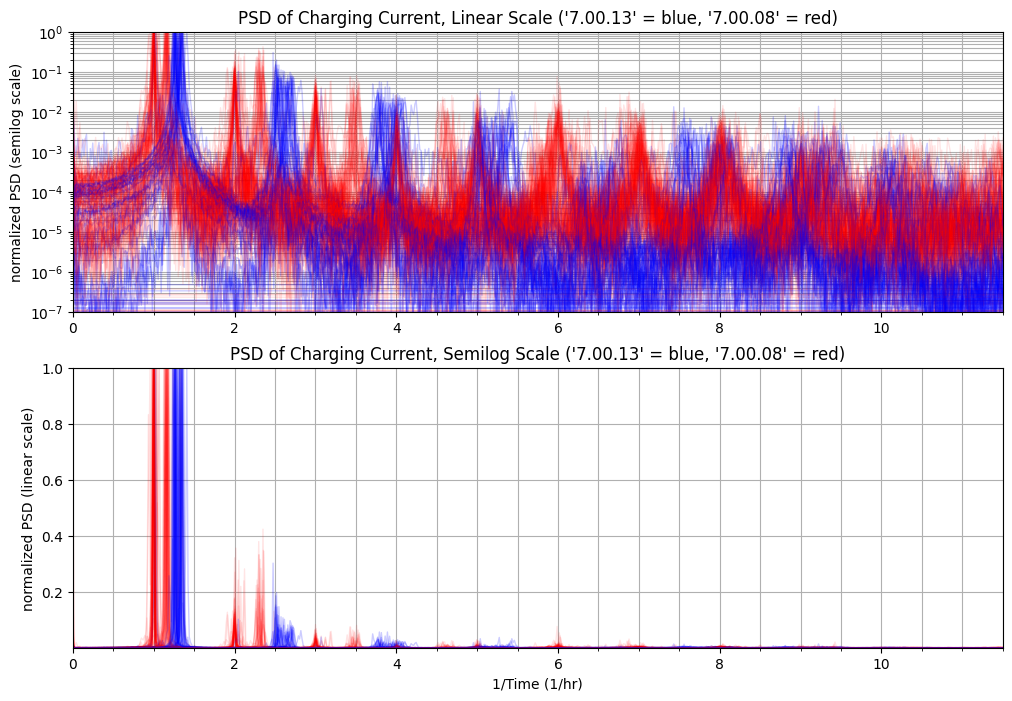

In [5]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.title("PSD of Charging Current, Linear Scale ('7.00.13' = blue, '7.00.08' = red)")
for PSD in PSDs[::]:
    filename_prefix = PSD[0]
    Freqs = PSD[-3]
    CC_PSD =PSD[-2]
    schedule_version = PSD[1]
    alpha = 0.2

    if schedule_version == '7.00.13':
        color = 'blue'
    else:
        color = 'red'
        alpha /= 2

    plt.plot(Freqs, CC_PSD/CC_PSD[5:].max(), 
             label = schedule_version, color = color, 
             alpha = alpha, 
             linewidth = 1)

plt.semilogy()
plt.xlim(0,10)
plt.ylim(1e-7,1)
plt.xticks(np.arange(0,12,0.5), minor = True, fontsize = 0)
plt.grid( which = 'both')
plt.ylabel("normalized PSD (semilog scale)")


# plt.figure(figsize = (12,8))
plt.subplot(2,1,2)
plt.title("PSD of Charging Current, Semilog Scale ('7.00.13' = blue, '7.00.08' = red)")
for PSD in PSDs[::]:
    filename_prefix = PSD[0]
    Freqs = PSD[-3]
    CC_PSD =PSD[-2]
    schedule_version = PSD[1]
    alpha = 0.2

    if schedule_version == '7.00.13':
        color = 'blue'
    else:
        color = 'red'
        alpha /= 2

    plt.plot(Freqs, CC_PSD/CC_PSD[5:].max(), 
             label = schedule_version, color = color,
             alpha = alpha, 
             linewidth = 1)
# plt.legend()
plt.xlim(0,10)
plt.ylim(1e-7,1)
plt.xticks(np.arange(0,12,0.5), minor = True)
plt.grid( which = 'both')
plt.xlabel("1/Time (1/hr)")
plt.ylabel("normalized PSD (linear scale)")

plt.savefig('figures/PSD_CC.png')

# Plot PSD for Charging Voltage

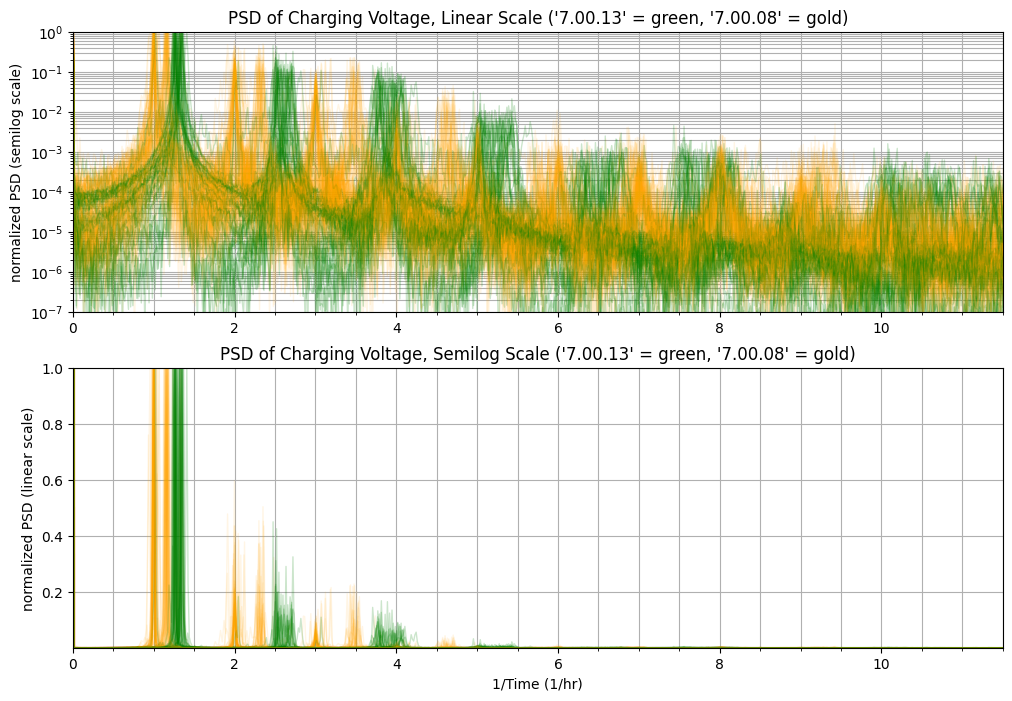

In [6]:
plt.figure(figsize = (12, 8))
plt.subplot(2,1,1)
plt.title("PSD of Charging Voltage, Linear Scale ('7.00.13' = green, '7.00.08' = gold)")
for PSD in PSDs[::]:
    filename_prefix = PSD[0]
    Freqs = PSD[-3]
    CV_PSD =PSD[-1]
    schedule_version = PSD[1]
    alpha = 0.2

    if schedule_version == '7.00.13':
        color = 'green'
    else:
        color = 'orange'
        alpha /= 2

    plt.plot(Freqs, CV_PSD/CV_PSD[5:].max(), 
             label = schedule_version, color = color, 
             alpha = alpha, 
             linewidth = 1)

# plt.legend()
plt.semilogy()
plt.xlim(0,10)
plt.ylim(1e-7,1)
plt.xticks(np.arange(0,12,0.5), minor = True, fontsize = 0)
plt.grid( which = 'both')
plt.ylabel("normalized PSD (semilog scale)")
# plt.show()


# plt.figure(figsize = (12, 8))
plt.subplot(2,1,2)
plt.title("PSD of Charging Voltage, Semilog Scale ('7.00.13' = green, '7.00.08' = gold)")
for PSD in PSDs[::]:
    filename_prefix = PSD[0]
    Freqs = PSD[-3]
    CV_PSD =PSD[-1]
    schedule_version = PSD[1]
    alpha = 0.2

    if schedule_version == '7.00.13':
        color = 'green'
    else:
        color = 'orange'
        alpha /= 2

    plt.plot(Freqs, CV_PSD/CV_PSD[5:].max(), 
             label = schedule_version, color = color,
             alpha = alpha, 
             linewidth = 1)
# plt.legend()
plt.xlim(0,10)
plt.ylim(1e-7,1)
plt.xticks(np.arange(0,12,0.5), minor = True)
plt.grid( which = 'both')
plt.xlabel("1/Time (1/hr)")
plt.ylabel("normalized PSD (linear scale)")
# plt.show()
plt.savefig('figures/PSD_CV.png')

In [7]:
with gzip.open('data/CC_data_frames_FFT.pckl', 'wb') as f:
    pickle.dump(CC_peaks_list, f)
with gzip.open('data/CV_data_frames_FFT.pckl', 'wb') as f:
    pickle.dump(CV_peaks_list, f)